# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa18.github.io/assignments2018/assignment1) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs682.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs682.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs682.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
num_folds = 5
# Your code X_dev, y_dev
X_train_folds = np.array_split(X_train_feats, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
small_num_iters = 1000 # the original is 1500
num_folds = 5
#go through each k 
for i in range (0, len(learning_rates)):
    for n in range (0, len(regularization_strengths)):
        #for each part we are going to use as test
        templr = learning_rates[i]
        temprs = regularization_strengths[n]
        results[(templr, temprs)]=[]
        #for each fold of the cross validation
        for j in range (0, num_folds):
            #train the model using the four parts
            #get the four parts
            temparray4_x = []
            temparray4_y = []
            for k in range (0, num_folds):
                if(k!=j):
                    temparray4_x.append(X_train_folds[k])
                    temparray4_y.append(y_train_folds[k])
            temptrain_X = np.concatenate(temparray4_x)
            temptrain_y = np.concatenate(temparray4_y)
        
            #get the test data
            temptest_X = X_train_folds[j]
            temptest_y = y_train_folds[j]
            
            #svm
            tempclassifier = LinearSVM()
            tempclassifier.train(temptrain_X, temptrain_y, learning_rate=templr, reg=temprs,
                      num_iters=small_num_iters, verbose=True)
        
            #vali pred
            temppred_y = tempclassifier.predict(temptest_X)
            #training pred
            temppred_y_tr = tempclassifier.predict(temptrain_X)
            
            accuracy_t = np.mean(temppred_y_tr == temptrain_y)
            accuracy_v = np.mean(temppred_y == temptest_y)


        
            #append to the tempacu
            results[(templr, temprs)] = (accuracy_t,accuracy_v)
            
            if accuracy_v > best_val:
                best_val = accuracy_v
                best_svm = tempclassifier




################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 46.565955
iteration 100 / 1000: loss 46.188990
iteration 200 / 1000: loss 45.817952
iteration 300 / 1000: loss 45.436776
iteration 400 / 1000: loss 45.112992
iteration 500 / 1000: loss 44.742445
iteration 600 / 1000: loss 44.379731
iteration 700 / 1000: loss 44.014832
iteration 800 / 1000: loss 43.673084
iteration 900 / 1000: loss 43.329180
iteration 0 / 1000: loss 48.116268
iteration 100 / 1000: loss 47.730673
iteration 200 / 1000: loss 47.333571
iteration 300 / 1000: loss 46.960796
iteration 400 / 1000: loss 46.594277
iteration 500 / 1000: loss 46.209855
iteration 600 / 1000: loss 45.842176
iteration 700 / 1000: loss 45.460685
iteration 800 / 1000: loss 45.113288
iteration 900 / 1000: loss 44.749886
iteration 0 / 1000: loss 46.606342
iteration 100 / 1000: loss 46.224055
iteration 200 / 1000: loss 45.852874
iteration 300 / 1000: loss 45.506268
iteration 400 / 1000: loss 45.138724
iteration 500 / 1000: loss 44.769707
iteration 600 / 1000: loss 44.426284
iterati

iteration 500 / 1000: loss 11.540661
iteration 600 / 1000: loss 9.931955
iteration 700 / 1000: loss 9.341608
iteration 800 / 1000: loss 9.125290
iteration 900 / 1000: loss 9.045956
iteration 0 / 1000: loss 420.293226
iteration 100 / 1000: loss 159.915975
iteration 200 / 1000: loss 64.386740
iteration 300 / 1000: loss 29.327523
iteration 400 / 1000: loss 16.457767
iteration 500 / 1000: loss 11.736717
iteration 600 / 1000: loss 10.004453
iteration 700 / 1000: loss 9.368475
iteration 800 / 1000: loss 9.134930
iteration 900 / 1000: loss 9.049497
iteration 0 / 1000: loss 387.007222
iteration 100 / 1000: loss 147.717847
iteration 200 / 1000: loss 59.901950
iteration 300 / 1000: loss 27.678612
iteration 400 / 1000: loss 15.854207
iteration 500 / 1000: loss 11.516201
iteration 600 / 1000: loss 9.922746
iteration 700 / 1000: loss 9.338803
iteration 800 / 1000: loss 9.124230
iteration 900 / 1000: loss 9.045486
iteration 0 / 1000: loss 3896.762369
iteration 100 / 1000: loss 9.136233
iteration 200

In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.427


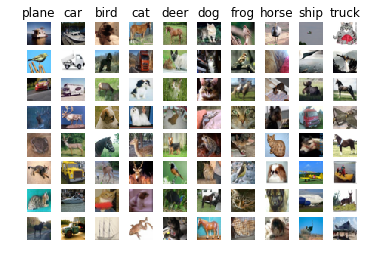

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
They look like the class object they have been labelled.It makes sense that these images are classified incorrectly because of this similarity.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)
checkrun = 0
print(checkrun)
checkrun += 1

(49000, 155)
(49000, 154)


In [29]:
from cs682.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
best_val = -1

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
learning_rates = [0.5, 0.7, 0.9]
learning_rate_decays = [0.95,0.85]
regularization_strengths = [0.001, 0.005]
temp_iters = 100

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
where = 0
X_train_folds = np.array_split(X_train_feats, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

for i in range (0, len(learning_rates)):
    for n in range (0, len(regularization_strengths)):
        for p in range (0, len(learning_rate_decays)):
                print(where, 40)
                where += 1
                #for each part we are going to use as test
                templr = learning_rates[i]
                temprs = regularization_strengths[n]
                tempdecay = learning_rate_decays[p]
                
                #for each fold of the cross validation
                for j in range (0, num_folds):
                    #train the model using the four parts
                    #get the four parts
                    temparray4_x = []
                    temparray4_y = []
                    for k in range (0, num_folds):
                        if(k!=j):
                            temparray4_x.append(X_train_folds[k])
                            temparray4_y.append(y_train_folds[k])
                    temptrain_X = np.concatenate(temparray4_x)
                    temptrain_y = np.concatenate(temparray4_y)
        
                    #get the test data
                    temptest_X = X_train_folds[j]
                    temptest_y = y_train_folds[j]
            
                    #svm

                    net.train(temptrain_X, temptrain_y, X_val_feats, y_val, num_iters=temp_iters, batch_size=200,
                                      learning_rate=templr, learning_rate_decay=tempdecay, reg=temprs, verbose=True)
        
                    #vali pred
                    temppred_y = net.predict(temptest_X)
                    #training pred
                    temppred_y_tr = net.predict(temptrain_X)
            
                    accuracy_t = np.mean(temppred_y_tr == temptrain_y)
                    accuracy_v = np.mean(temppred_y == temptest_y)


        
                    #append to the tempacu
                    results[(templr, temprs, tempdecay)] = (accuracy_t,accuracy_v)
            
                    if accuracy_v > best_val:
                        best_val = accuracy_v
                        best_net = net
                        best_para = [templr, temprs, tempdecay]

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

0 40
iteration 0 / 100: loss 2.302586
iteration 0 / 100: loss 1.483107
iteration 0 / 100: loss 1.466257
iteration 0 / 100: loss 1.346031
iteration 0 / 100: loss 1.268998
1 40
iteration 0 / 100: loss 1.449140
iteration 0 / 100: loss 1.274591
iteration 0 / 100: loss 1.306525
iteration 0 / 100: loss 1.287825
iteration 0 / 100: loss 1.227947
2 40
iteration 0 / 100: loss 1.563705
iteration 0 / 100: loss 1.491190
iteration 0 / 100: loss 1.515048
iteration 0 / 100: loss 1.406095
iteration 0 / 100: loss 1.573094
3 40
iteration 0 / 100: loss 1.503816
iteration 0 / 100: loss 1.421688
iteration 0 / 100: loss 1.410966
iteration 0 / 100: loss 1.348652
iteration 0 / 100: loss 1.523128
4 40
iteration 0 / 100: loss 1.268120
iteration 0 / 100: loss 1.265415
iteration 0 / 100: loss 1.164719
iteration 0 / 100: loss 1.460437
iteration 0 / 100: loss 1.216843
5 40
iteration 0 / 100: loss 1.206785
iteration 0 / 100: loss 1.093665
iteration 0 / 100: loss 1.248413
iteration 0 / 100: loss 1.170112
iteration 0 /

In [30]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
bestlr, bestrs, besdecay = best_para
best_net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=1000, batch_size=200,
                                      learning_rate=bestlr, learning_rate_decay=besdecay, reg=bestrs, verbose=True)
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

iteration 0 / 1000: loss 1.388077
iteration 100 / 1000: loss 1.316540
iteration 200 / 1000: loss 1.468729
iteration 300 / 1000: loss 1.199869
iteration 400 / 1000: loss 1.119414
iteration 500 / 1000: loss 1.124283
iteration 600 / 1000: loss 1.060119
iteration 700 / 1000: loss 1.091164
iteration 800 / 1000: loss 1.090957
iteration 900 / 1000: loss 1.075073
0.577
